<a href="https://colab.research.google.com/github/NIETOCAMBRON7/Simulacion-2/blob/main/Gestion_de_Trafico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Nieto Cambrón Daniel Alejandro
### Simulación 2

## Problema de Gestión de Tráfico con Líneas de Espera:

Imagina que eres el gerente de tráfico de una ciudad y te han asignado la tarea de optimizar el flujo de vehículos en un cruce de calles con mucho tráfico. El cruce de calles cuenta con semáforos que pueden controlar el flujo de tráfico en cada dirección. Sin embargo, debido al alto volumen de vehículos, a menudo se forman largas filas de autos en cada uno de los semáforos, lo que resulta en retrasos significativos y frustración para los conductores.

El objetivo es minimizar el tiempo de espera promedio de los conductores en el cruce de calles implementando un sistema de gestión de tráfico eficiente. Para ello, debes tener en cuenta los siguientes detalles:

1.   Cada semáforo puede tener diferentes ciclos de tiempo para permitir el flujo de vehículos en cada dirección.
2.   El número de vehículos que llegan a cada semáforo varía a lo largo del día.
Los vehículos que llegan a cada semáforo forman una línea de espera antes de que se les permita pasar.
3.    Cada vehículo necesita un tiempo determinado para cruzar el cruce de calles.
4.    Puedes ajustar la duración del ciclo de los semáforos y la secuencia en la que cambian de un color a otro.
5.    Se debe tener en cuenta las restricciones de seguridad vial y evitar congestiones innecesarias o situaciones peligrosas.
6.    Todo lo anterior consiste en desarrollar un modelo de gestión de tráfico que considere todos estos factores y encuentre la configuración óptima para los semáforos, minimizando el tiempo de espera promedio de los conductores y maximizando el flujo de vehículos a través del cruce de calles.


### Solución:
Para resolver este problema se utilizará simulacion en Python, Se considerará un crucero donde pasa una avenida principal de doble carril uno que va de norte a sur y otro de sur a norte, y el cruce lo hara con calle 1 va de este a oeste, ahora bien se tienen 3 semaforos sincrono,s es decir, la avenida principal tiene 2 semaforos uno para norte a sur y otro de sur a norte, los cuales deben de marcar al mismo tiempo los cambios de verde, amarillo y rojo, y al mismo tiempo estan sincronos al semaforo del cruce de calle 1, el cual el tiempo del semaforo en rojo es igual a la suma de los tiempos del tiempo de la luz amarilla +  luz verde de cualquiera de los semaforos de la avenida principal

Los carros van llegando de forma aleatoria en un tiempo no mayor a 20 segundos entre carro y carro.

y nos cuestionaremos lo siguiente: ¿cuanto es el tiempo maximo que deben esperar un auto?, y ¿cual es la configuracion del semaforo que optimice el tiempo maximo de espera de cada auto?

In [3]:
pip install simpy


### Diagrama

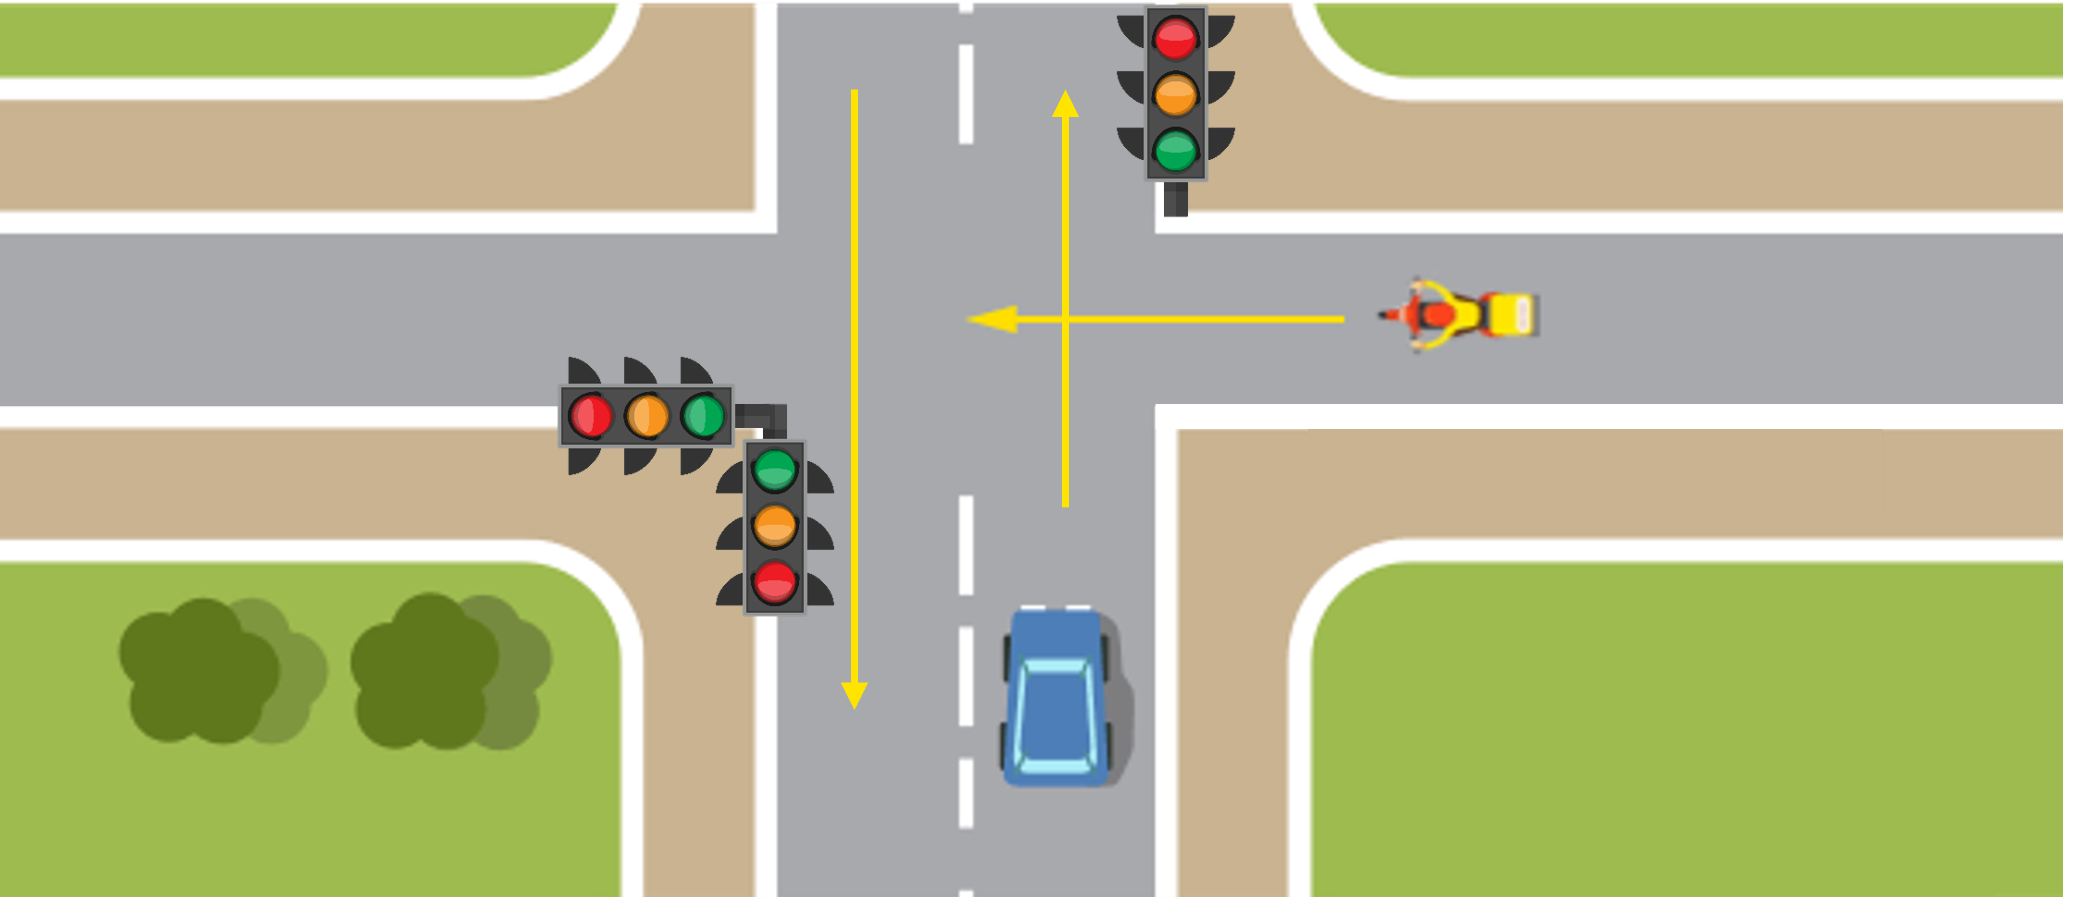

Para resolver este problema se usara simulación en Python, se utilizara la biblioteca simpy, que es una biblioteca de simulación de eventos discretos.

 El objetivo es encontrar la mejor configuración de los semáforos para minimizar el tiempo de espera de los autos en la intersección.

In [4]:
import simpy
import random
import statistics
import numpy as np
import copy

Se comienza definiendo varios parámetros de la simulación, como el tiempo total de simulación, el intervalo de llegada entre carros, la duración del tiempo verde y amarillo de los semáforos, el tamaño de la población para el algoritmo genético, el número de generaciones y la probabilidad de mutación.

In [5]:
# Parámetros de la simulación
TIEMPO_SIMULACION = 3600 # Una hora # Tiempo total de simulación en segundos
INTERVALO_LLEGADA = 20  # Intervalo de llegada entre carros en segundos

# Configuración de los semáforos (configuración inicial)
DURACION_VERDE_INICIAL = 30  # Duración del tiempo verde del semáforo
DURACION_AMARILLO_INICIAL = 5  # Duración del tiempo amarillo del semáforo

A grandes rasgos, un algoritmo genético en Python (o programacion en general) es una técnica de optimización inspirada en el proceso de evolución natural. Se basa en la idea de que una población de soluciones candidatas evoluciona y se mejora iterativamente para encontrar una solución óptima a un problema dado.

In [6]:
# Parámetros del algoritmo genético

POBLACION_SIZE = 10  # Tamaño de la población
# Indica el tamaño de la población, es decir, la cantidad de configuraciones
# de semáforos que se considerarán en cada generación del algoritmo.
# En este caso, se establece en 10, lo que significa que habrá 10
# Configuraciones de semáforos diferentes en cada generación.

NUM_GENERACIONES = 10  # Número de generaciones
# Determina el número de generaciones que se ejecutarán en el algoritmo
# genético. Cada generación representa una iteración del proceso de
# reproducción, cruce y mutación de las configuraciones de semáforos.
# En este caso, se establece en 10, lo que implica que se realizarán 10
# iteraciones del algoritmo.

MUTACION_PROBABILIDAD = 0.2  # Probabilidad de mutación
# Indica la probabilidad de que ocurra una mutación en una configuración de
# semáforos durante el proceso de evolución. En este caso, se establece en 0.2,
# lo que significa que hay una probabilidad del 20% de que una configuración
# mute durante el algoritmo genético.

Clase ***CruceCalles***: Esta clase representa el cruce de calles y contiene los recursos necesarios para controlar los semáforos. Los recursos se definen utilizando la biblioteca simpy. Los parámetros **duracion_verde** y **duracion_amarillo** indican la duración del tiempo en verde y amarillo de los semáforos respectivamente.

El método *cambiar_semaforos* simula el cambio de los semáforos y utiliza un objeto yield para esperar a que se obtenga acceso a uno de los recursos (semáforos). El método esperar simula el tiempo de espera de un carro en la intersección.

In [7]:
class CruceCalles:
    def __init__(self, env, duracion_verde, duracion_amarillo):
        self.env = env
        self.sem_norte_sur = simpy.Resource(env, capacity=1)
        self.sem_sur_norte = simpy.Resource(env, capacity=1)
        self.sem_este_oeste = simpy.Resource(env, capacity=1)
        self.duracion_verde = duracion_verde
        self.duracion_amarillo = duracion_amarillo

    def cambiar_semaforos(self):
        with self.sem_norte_sur.request() as req1, \
             self.sem_sur_norte.request() as req2, \
             self.sem_este_oeste.request() as req3:

            yield req1 | req2 | req3  # Esperar a que se obtenga alguno de los recursos

            yield self.env.timeout(self.duracion_verde)

    def esperar(self, tiempo_espera):
        yield self.env.timeout(tiempo_espera)


Función ***llegada_auto***: Esta función modela la llegada de los carros al cruce de calles. Se ejecuta en bucle infinito y utiliza un temporizador aleatorio para simular la llegada periódica de carros. Cada vez que llega un carro, se crea un objeto *Carro* y se inicia el proceso de cruce llamando al *método cruzar del objeto Carro.*

Clase ***Carro***: Esta clase representa un carro y contiene la referencia al objeto* CruceCalles* y una lista *tiempos_espera* para almacenar los tiempos de espera de los carros en la intersección. En el *método cruzar*, se elige aleatoriamente un tiempo de espera dentro de la duración verde del semáforo y se agrega a la lista de tiempos de espera. Luego, se utiliza yield para esperar a que se complete el tiempo de espera simulado utilizando el método *esperar de la clase CruceCalles.*

In [8]:
def llegada_auto(env, cruce_calles, tiempos_espera):
    while True:
        yield env.timeout(random.randint(0, INTERVALO_LLEGADA))

        carro = Carro(env, cruce_calles, tiempos_espera)
        env.process(carro.cruzar())

class Carro:
    def __init__(self, env, cruce_calles, tiempos_espera):
        self.env = env
        self.cruce_calles = cruce_calles
        self.tiempos_espera = tiempos_espera

    def cruzar(self):
        tiempo_espera = random.randint(0, self.cruce_calles.duracion_verde)
        self.tiempos_espera.append(tiempo_espera)
        yield self.env.process(self.cruce_calles.esperar(tiempo_espera))

Función ***evaluar_configuracion***: Esta función evalúa una configuración específica de los semáforos y devuelve el tiempo promedio de espera de los carros en la intersección. Crea un entorno simpy.Environment, una lista tiempos_espera y un objeto CruceCalles con la configuración proporcionada.

Luego, inicia el proceso de llegada de los carros al cruce utilizando la función ***llegada_auto ***y ejecuta la simulación hasta que se alcance el tiempo total de simulación definido por TIEMPO_SIMULACION. Al final, se calcula la media de los tiempos de espera registrados en la lista **tiempos_espera**.

In [9]:
def evaluar_configuracion(configuracion):
    env = simpy.Environment()
    tiempos_espera = []
    cruce_calles = CruceCalles(env, configuracion[0], configuracion[1])
    env.process(llegada_auto(env, cruce_calles, tiempos_espera))
    env.run(until=TIEMPO_SIMULACION)

    return statistics.mean(tiempos_espera)

Funciones ***generar_poblacion_inicial y seleccion_padres***: Estas funciones están relacionadas con la etapa del algoritmo genético que involucra la generación de una población inicial y la selección de los padres para la reproducción.

La función ***generar_poblacion_inicial*** crea una lista de configuraciones de semáforos aleatorias dentro de rangos predefinidos. La función ***seleccion_padres*** evalúa el rendimiento de cada configuración y selecciona dos padres de la población basándose en sus valores de rendimiento de cada configuración. La probabilidad de selección se determina mediante la distribución de este rendimiento.

In [10]:
def generar_poblacion_inicial():
    poblacion = []
    for _ in range(POBLACION_SIZE):
        duracion_verde = np.random.randint(10, 60)
        duracion_amarillo = np.random.randint(3, 10)
        poblacion.append([duracion_verde, duracion_amarillo])
    return poblacion

def seleccion_padres(poblacion):
    fitness = [evaluar_configuracion(configuracion) for configuracion in poblacion]
    padres_indices = np.random.choice(range(POBLACION_SIZE), size=2, replace=False, p=fitness/np.sum(fitness))
    padres = [poblacion[indice] for indice in padres_indices]
    return padres

Funciones ***cruzar y mutar***: Estas funciones realizan las operaciones de cruce y mutación en las configuraciones de semáforos. La función cruzar toma dos padres y genera dos hijos intercambiando partes de las configuraciones de los padres. La función ***mutar*** introduce cambios aleatorios en una configuración con una probabilidad definida por *MUTACION_PROBABILIDAD.*

In [11]:
def cruzar(padre1, padre2):
    hijo1 = [padre1[0], padre2[1]]
    hijo2 = [padre2[0], padre1[1]]
    return hijo1, hijo2

def mutar(configuracion):
    if random.random() < MUTACION_PROBABILIDAD:
        configuracion[0] = np.random.randint(10, 60)
    if random.random() < MUTACION_PROBABILIDAD:
        configuracion[1] = np.random.randint(3, 10)

Función ***optimizar_semáforos***: Esta función lleva a cabo el proceso de optimización utilizando el algoritmo genético. Comienza generando una población inicial llamando a ***generar_poblacion_inicial***. Luego, se itera a través de un número predefinido de generaciones. En cada generación, se seleccionan padres utilizando ***seleccion_padres***, se generan nuevos hijos mediante cruce y mutación, y se actualiza la población con los nuevos hijos. Al final, se devuelve la mejor configuración encontrada y el tiempo máximo de espera asociado a esa configuración.

In [18]:
def optimizar_semáforos():
    poblacion = generar_poblacion_inicial()

    for _ in range(NUM_GENERACIONES):
        nuevos_hijos = []

        for _ in range(int(POBLACION_SIZE/2)):
            padre1, padre2 = seleccion_padres(poblacion)
            hijo1, hijo2 = cruzar(padre1, padre2)
            mutar(hijo1)
            mutar(hijo2)
            nuevos_hijos.extend([hijo1, hijo2])

        poblacion = copy.deepcopy(nuevos_hijos)

    mejor_configuracion = max(poblacion, key=evaluar_configuracion)
    tiempo_max_espera = evaluar_configuracion(mejor_configuracion)

    return mejor_configuracion, tiempo_max_espera

 Finalmente, se muestra en la consola la mejor configuración de los semáforos encontrada y el tiempo máximo de espera asociado a esa configuración.

In [21]:
# Optimización de los semáforos
mejor_configuracion, tiempo_max_espera = optimizar_semáforos()

# Resultados
print("Mejor configuración de los semáforos: ", mejor_configuracion)
print("Tiempo máximo de espera con la mejor configuración: ", tiempo_max_espera)


Mejor configuración de los semáforos:  [58, 8]
Tiempo máximo de espera con la mejor configuración:  30.8328530259366


## Con simulación

Ahora bien, el proceso anterior lo vamos a repetir ***NUM_SIMULACIONES = 100*** Para asi tener un mejor campo de presición en nuestros ***Resultados.***

In [24]:
# Realizar la simulación múltiples veces
tiempos_max_espera = []
tiempos_verde = []
tiempos_amarillo = []
NUM_SIMULACIONES = 100
for _ in range(NUM_SIMULACIONES):
    mejor_configuracion, tiempo_max_espera = optimizar_semáforos()
    tiempos_max_espera.append(tiempo_max_espera)
    tiempos_verde.append(mejor_configuracion[0])
    tiempos_amarillo.append(mejor_configuracion[1])

# Calcular estadísticas
tiempo_promedio_max_espera = statistics.mean(tiempos_max_espera)
tiempo_promedio_verde = statistics.mean(tiempos_verde)
tiempo_promedio_amarillo = statistics.mean(tiempos_amarillo)

# Resultados
print("Tiempo promedio máximo de espera de los vehículos: ", tiempo_promedio_max_espera)
print("Tiempo promedio de duración del semáforo verde: ", tiempo_promedio_verde)
print("Tiempo promedio de duración del semáforo amarillo: ", tiempo_promedio_amarillo)


Tiempo promedio máximo de espera de los vehículos:  27.255274039010715
Tiempo promedio de duración del semáforo verde:  54.61
Tiempo promedio de duración del semáforo amarillo:  5.57


## Generando un grafico de convergencia

In [25]:
import matplotlib.pyplot as plt

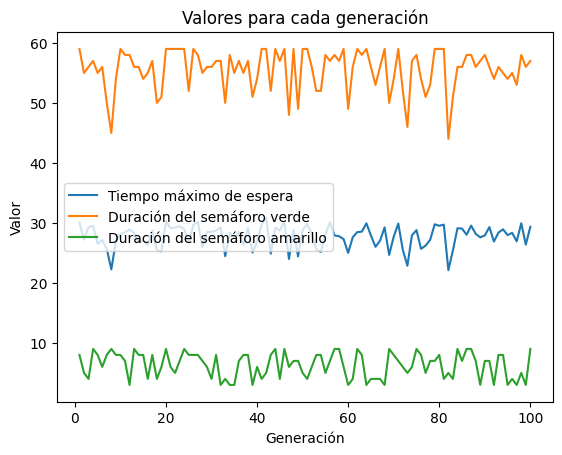

In [28]:
import matplotlib.pyplot as plt

# Realizar la simulación múltiples veces
tiempos_max_espera = []
tiempos_verde = []
tiempos_amarillo = []
NUM_SIMULACIONES = 100

for _ in range(NUM_SIMULACIONES):
    mejor_configuracion, tiempo_max_espera = optimizar_semáforos()
    tiempos_max_espera.append(tiempo_max_espera)
    tiempos_verde.append(mejor_configuracion[0])
    tiempos_amarillo.append(mejor_configuracion[1])

# Crear gráfico de convergencia
generaciones = range(1, NUM_SIMULACIONES + 1)

plt.plot(generaciones, tiempos_max_espera, label='Tiempo máximo de espera')
plt.plot(generaciones, tiempos_verde, label='Duración del semáforo verde')
plt.plot(generaciones, tiempos_amarillo, label='Duración del semáforo amarillo')

plt.xlabel('Generación')
plt.ylabel('Valor')
plt.title('Valores para cada generación')
plt.legend()

# Mostrar el gráfico
plt.show()


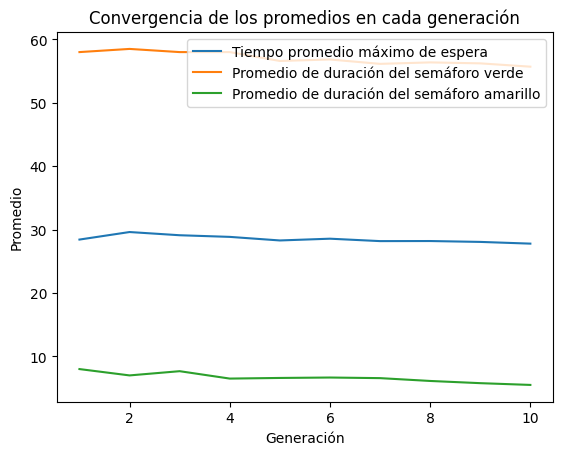

In [27]:
import matplotlib.pyplot as plt

# Realizar la simulación múltiples veces
tiempos_max_espera = []
tiempos_verde = []
tiempos_amarillo = []
promedios_max_espera = []
promedios_verde = []
promedios_amarillo = []
NUM_SIMULACIONES = 10
for i in range(NUM_SIMULACIONES):
    mejor_configuracion, tiempo_max_espera = optimizar_semáforos()
    tiempos_max_espera.append(tiempo_max_espera)
    tiempos_verde.append(mejor_configuracion[0])
    tiempos_amarillo.append(mejor_configuracion[1])

    promedio_max_espera = statistics.mean(tiempos_max_espera)
    promedio_verde = statistics.mean(tiempos_verde)
    promedio_amarillo = statistics.mean(tiempos_amarillo)

    promedios_max_espera.append(promedio_max_espera)
    promedios_verde.append(promedio_verde)
    promedios_amarillo.append(promedio_amarillo)

# Crear gráfico de convergencia
generaciones = range(1, NUM_SIMULACIONES + 1)

plt.plot(generaciones, promedios_max_espera, label='Tiempo promedio máximo de espera')
plt.plot(generaciones, promedios_verde, label='Promedio de duración del semáforo verde')
plt.plot(generaciones, promedios_amarillo, label='Promedio de duración del semáforo amarillo')

plt.xlabel('Generación')
plt.ylabel('Promedio')
plt.title('Convergencia de los promedios en cada generación')
plt.legend()

# Mostrar el gráfico
plt.show()
